In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../src/')

### Load dataset

In [2]:
df_train = pd.read_csv('../dataset/train.csv')
df_train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [3]:
df_train.shape

(159571, 8)

### EDA

We'll start by counting the different labels in each category

In [5]:
categories = df_train.columns[2:]
df_train[categories].sum()
# Add nothing

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

Let's try to see how many examples don't have labels at all:

In [4]:

categories = df_train.columns[2:]
no_labels = (df_train[categories].sum(axis=1) == 0).sum()
with_labels = (df_train[categories].sum(axis=1) > 0).sum()

print(f'With labels: {with_labels}. Percentage: {round(with_labels / len(df_train), 3) * 100}%')
print(f'No labels: {no_labels}. Percentage: {round(no_labels / len(df_train), 3) * 100}%')

With labels: 16225. Percentage: 10.2%
No labels: 143346. Percentage: 89.8%


As you can see, there is a large imbalance in this dataset.

Let's try to look at the label distribution:

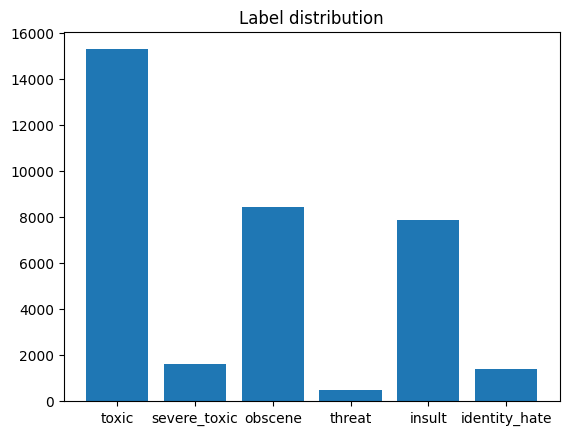

In [4]:
import matplotlib.pyplot as plt

categories = df_train.columns[2:]
plt.title('Label distribution')
plt.bar(categories, df_train[categories].sum());
# add nothing bar

Let's try to visualize the distribution comments having 1 to 6 labels:

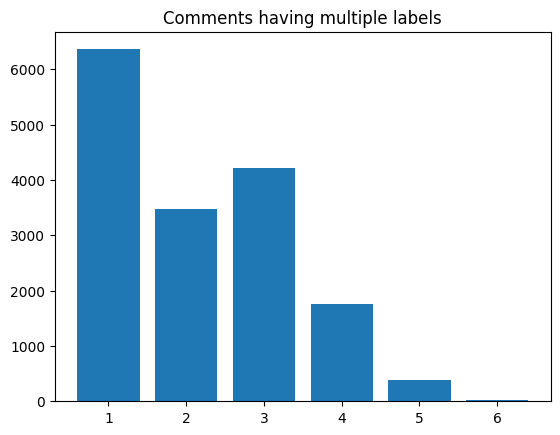

In [32]:
categories = df_train.columns[2:]
counts = df_train[categories].sum(axis=1)
counts = counts[counts > 0]
counts = counts.value_counts()
plt.title('Comments having multiple labels')
plt.bar(counts.index, counts);

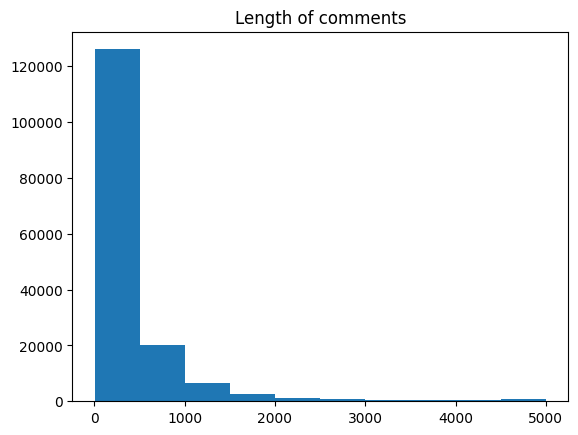

In [33]:
comment_lengths = df_train['comment_text'].str.len()
plt.hist(comment_lengths)
plt.title('Length of comments');

We can visualize the words in the corpus using word cloud:

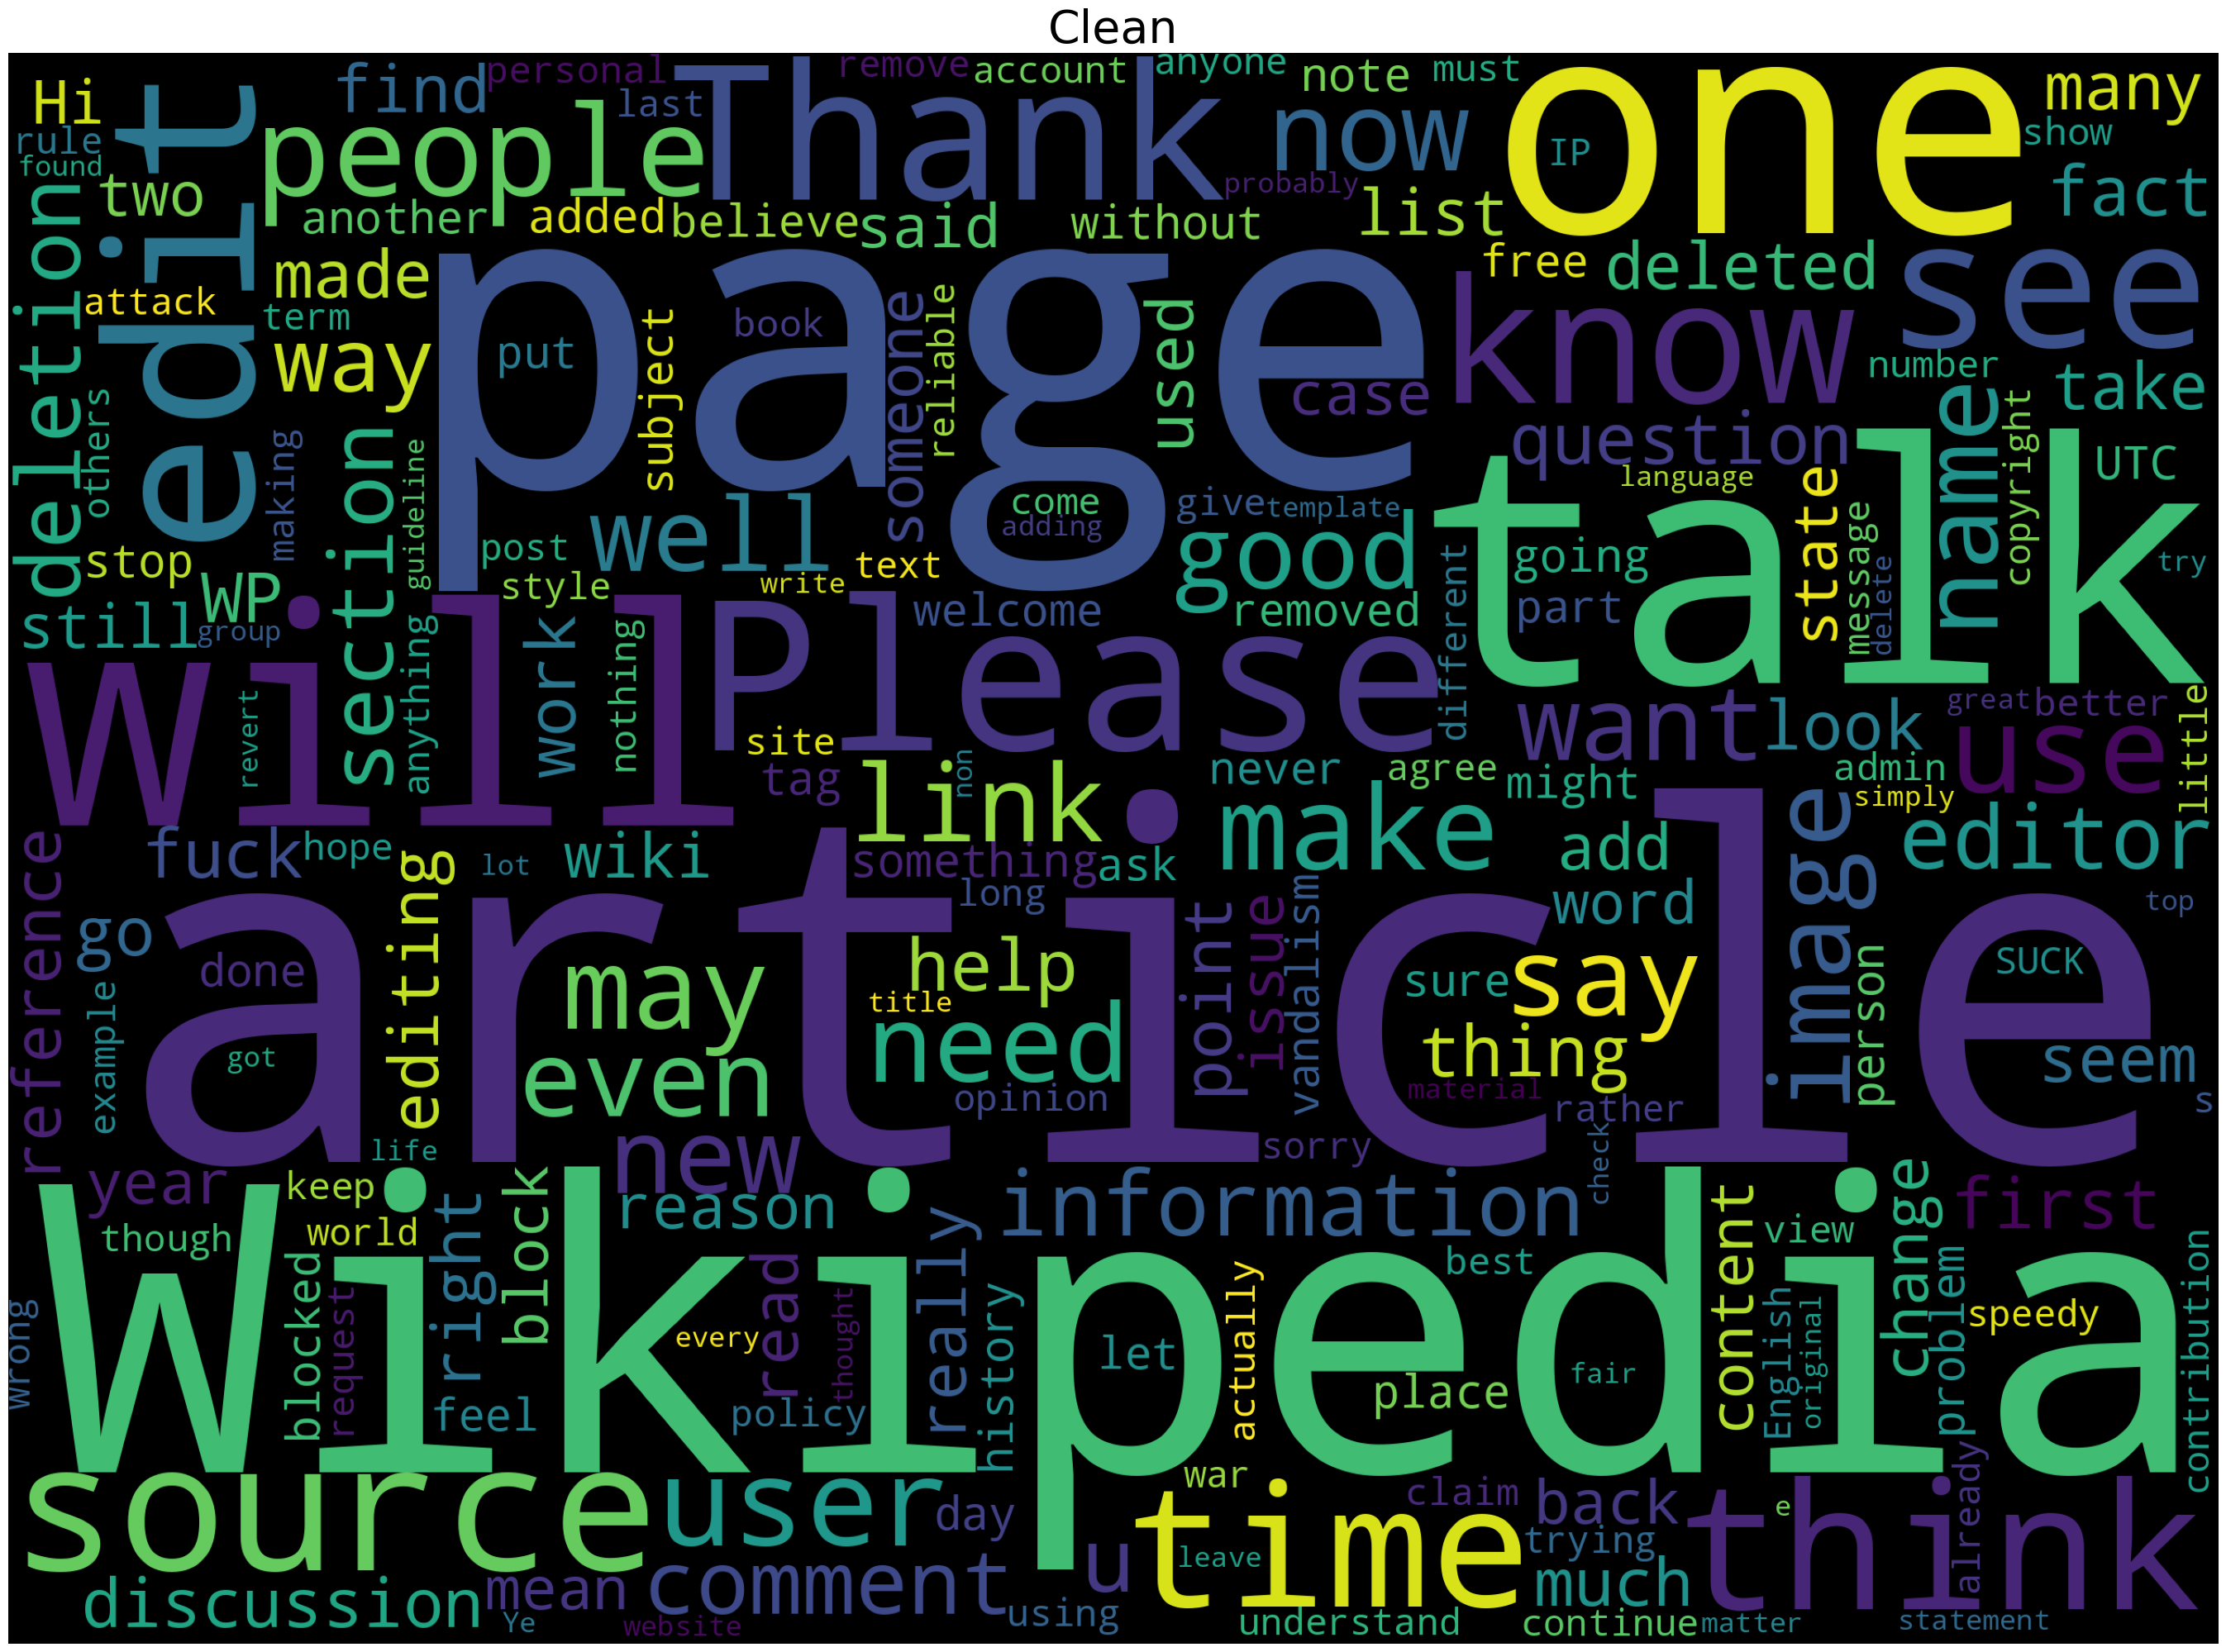

In [6]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize=(40, 25))
text = df_train.comment_text.values
cloud_toxic = WordCloud(stopwords=STOPWORDS, background_color='black', collocations=False, width=2500, height=1800).generate(" ".join(text))

plt.axis('off')
plt.title("Clean",fontsize=40)
plt.imshow(cloud_toxic);

### Preprocessing

After we've explored the dataset a bit, let's clean it.
In this example, we'll do a bit aggressive cleaning. Namely, we'll:
* Remove stop words
* Remove non-english characters
* Remove punctuation
* Remove URLs
* Lowercase comments
* Remove newlines
* Remove whitespaces
* Remove numbers

This is to get a quick baseline and to decrease the variance in the comments. The downside is that we'll lose information. Let's see how it plays out.

In [5]:
import os
import string
from typing import List

import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm.auto import tqdm
from utils import hash_split

tqdm.pandas()

# Download packages from NLTK
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = stopwords.words("english")
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
lemmatizer = WordNetLemmatizer()

def remove_non_english_characters(comments: pd.Series):
    # Create a string with all English characters
    english_characters = string.ascii_letters + string.digits + string.punctuation + " "
    pattern = r"[^" + english_characters + "]"

    # Use a generator comprehension to remove any characters that are not in the english_characters string
    _comments = comments.str.replace(pattern, "", regex=True)
    return _comments


def remove_stop_words(comments: pd.Series):
    pattern = r"\b(?:{})\b".format("|".join(stop_words))
    _comments = comments.str.replace(pattern, "", regex=True)
    return _comments


def preprocess_comments(comments: List[str] | pd.Series) -> pd.Series:
    if not isinstance(comments, pd.Series):
        comments = pd.Series(comments)

    # Lowercase
    comments = comments.str.lower()
    # Remove stopwords
    comments = remove_stop_words(comments)
    # Remove non-english characters
    comments = remove_non_english_characters(comments)
    # Remove punctuation & backslash
    comments = comments.str.replace("[{}]".format(string.punctuation), "", regex=True)
    comments = comments.str.replace("\\", "", regex=True)
    # Remove URLs
    comments = comments.str.replace(r"http\S+", "", regex=True)
    # Remove newlines
    comments = comments.str.replace("\n", "")
    # Remove numbers
    comments = comments.str.replace(r"\d+", "", regex=True)
    # Remove whitespaces
    comments = comments.str.strip()
    comments = comments.str.replace(r"\s+", " ", regex=True)
    # Lemmatizing
    # comments = comments.progress_apply(lambda text: ' '.join([stemmer.stem(word) for word in text.split()]))
    comments = comments.progress_apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))
    comments = comments.progress_apply(
        lambda text: " ".join([lemmatizer.lemmatize(word, pos="v") for word in text.split()])
    )

    return comments


def preprocess_df(df):
    df_copy = df.copy()
    df_copy["comment_text"] = preprocess_comments(df_copy["comment_text"])
    df_copy = df_copy[df_copy["comment_text"] != ""]
    df_copy = df_copy.drop_duplicates(["comment_text"])
    return df_copy

df_processed = preprocess_df(df_train)

/home/ubuntu/.cache/pypoetry/virtualenvs/toxicity-kaggle-OHb9-QKz-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 159571/159571 [00:20<00:00, 7774.07it/s]


In [7]:
df_processed.shape

(157576, 8)

Let's see some examples of comments before & after the preprocessing:

In [21]:
from pandas import option_context
with option_context('display.max_colwidth', 120):
    df_compare = df_processed.drop(columns=labels).merge(df_train.drop(columns=labels), on='id')
    display(df_compare[:20])

,id,comment_text_x,comment_text_y
0,0000997932d777bf,explanation edit make username hardcore metallica fan revert vandalism closure gas vote new york doll fac please rem...,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, jus..."
1,000103f0d9cfb60f,aww match background colour seemingly stick thank talk january utc,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)"
2,000113f07ec002fd,hey man really try edit war guy constantly remove relevant information talk edit instead talk page seem care format ...,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and ..."
3,0001b41b1c6bb37e,make real suggestion improvement wonder section statistic later subsection type accident think reference may need ti...,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on,..."
4,0001d958c54c6e35,sir hero chance remember page,"You, sir, are my hero. Any chance you remember what page that's on?"
5,00025465d4725e87,congratulation well use tool well talk,"""\n\nCongratulations from me as well, use the tools well. · talk """
6,0002bcb3da6cb337,cocksucker piss around work,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7,00031b1e95af7921,vandalism matt shirvington article revert please ban,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned."
8,00037261f536c51d,sorry word nonsense offensive anyway intend write anything articlewow would jump vandalism merely request encycloped...,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow th..."
9,00040093b2687caa,alignment subject contrary dulithgow,alignment on this subject and which are contrary to those of DuLithgow


As you can see, the preprocesing is pretty aggressive, but for now it's okay.

Now, let's split them using hash split:

In [43]:
from dataset import hashed_train_test_split

df_train, df_valid = hashed_train_test_split(df_processed, valid_size=0.2)

print(f'Train size: {len(df_train)}')
print(f'Valid size: {len(df_valid)}')

Train size: 125820
Valid size: 31756


Now, let's load the model and the tokenizer using the `transformers` package:

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from dataset import labels

def load_model(model_name: str):
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(labels), problem_type="multi_label_classification"
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    return model, tokenizer

In [44]:
model_name = 'distilbert-base-uncased'
model, tokenizer = load_model(model_name)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

Next, we'll create a `Dataset` out of the CSV using Hugging Face's `Dataset` API. To create it, we need to pass the tokenizer so we'll get the token ids and the attention masks:

In [11]:
from datasets import Dataset

def create_dataset(df: pd.DataFrame, tokenizer, combine_labels=True):
    def _tokenize(example):
        return tokenizer(example["text"], truncation=True)

    def _merge_labels(example):
        example["labels"] = np.vstack([example[label] for label in labels]).T.astype("float")
        return example

    ds = Dataset.from_pandas(df)
    ds = ds.rename_column("comment_text", "text")
    if combine_labels:
        ds = ds.map(_merge_labels, batched=True)
        ds = ds.remove_columns(labels)
    ds = ds.map(_tokenize, batched=True)
    return ds

In [ ]:
ds_train = create_dataset(df_train, tokenizer)
ds_valid = create_dataset(df_valid, tokenizer)

One more thing before instantiating the Trainer and start training is, we need to implement our evaluation method. The evaluation method will be forwarded to the `Trainer` object, which will use it to evalute the model during training.

ATM, we'll compute several metrics in a weighted way:
* ROC-AUC
* F1
* Precision
* Recall
* Accuracy

In [14]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    scores = sigmoid(logits)
    predictions = (scores > 0.5).astype(int)

    roc_auc = roc_auc_score(labels, scores, average="weighted")
    f1 = f1_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    accuracy = accuracy_score(labels, predictions)

    return {
        "roc_auc": roc_auc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "accuracy": accuracy,
    }

Next, let's setup the `Trainer` and `TrainerArguments`. We'll use a couple of default values, like learning rate and batch size:

In [47]:
from transformers import EarlyStoppingCallback, TrainingArguments, Trainer

callbacks = [
    EarlyStoppingCallback(early_stopping_patience=10)
]

training_args = TrainingArguments(
    output_dir='./experiment',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=40,
    weight_decay=0.01,
    evaluation_strategy="steps",
    save_strategy="steps",
    metric_for_best_model="roc_auc",
    eval_steps=100,
    load_best_model_at_end=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_valid,
    tokenizer=tokenizer,
    callbacks=callbacks,
    compute_metrics=compute_metrics,
)

If you want to report to ClearML, simply change the `report_to="none"` to `report_to="clearml"`

Finally, let's train the model! As a reminder, we're going to fine tune a pre-trained distillbert on our corpus of toxic comments 😈🚀

In [48]:
trainer.train()
trainer.save_model("best_model")

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/home/ubuntu/.cache/pypoetry/virtualenvs/toxicity-kaggle-OHb9-QKz-py3.10/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 125820
  Num Epochs = 40
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 157280
  Number of trainable parameters = 66958086
You're using a DistilBertTokenizerFast tokenizer. Ple

Step,Training Loss,Validation Loss,Roc Auc,F1,Precision,Recall,Accuracy
100,No log,0.108863,0.920886,0.230284,0.579042,0.158627,0.897153
200,No log,0.067810,0.964142,0.647376,0.706983,0.597049,0.912300


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 31756
  Batch size = 32
/home/ubuntu/.cache/pypoetry/virtualenvs/toxicity-kaggle-OHb9-QKz-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Runni

KeyboardInterrupt: 

In [5]:
import torch
device = torch.device('cuda:0')

best_model, best_tokenizer = load_model('./best_model')
best_model = best_model.to(device)

Now, let's evaluate on the test set and submit the results to Kaggle using the Kaggle CLI:

In [12]:
df_test = pd.read_csv('../dataset/test.csv')
df_test = preprocess_df(df_test)
ds_test = create_dataset(df_test, best_tokenizer, combine_labels=False)

100%|██████████| 150/150 [00:05<00:00, 26.80ba/s]


In [20]:
import torch
from tqdm.auto import tqdm

def infer(model, tokenizer, dataset, batch_size=32):
    all_logits = np.zeros((len(dataset), len(labels)))

    for i in tqdm(range(0, len(dataset), batch_size)):
        start_idx = i
        end_index = min(start_idx + batch_size, len(dataset))

        batch = dataset[start_idx:end_index]
        batch = tokenizer.pad(batch)

        input_ids = torch.tensor(batch['input_ids']).to(device)
        attention_mask = torch.tensor(batch['attention_mask']).to(device)

        output = model(input_ids=input_ids, attention_mask=attention_mask)
        all_logits[start_idx:end_index] = output.logits.detach().cpu().numpy()
    
    scores = sigmoid(all_logits)
    predictions = (scores > 0.5).astype('int')
    return predictions

predictions = infer(best_model, best_tokenizer, ds_test)
ids = ds_test['id']

100%|██████████| 4684/4684 [06:25<00:00, 12.16it/s]


In [25]:
from dataset import labels

df_submission = df_test.copy().set_index('id')
df_submission = df_submission.drop(columns=['comment_text'])
df_submission[labels] = 0
df_submission.loc[ids] = predictions
df_submission = df_submission.reset_index()

df_submission.to_csv('submission.csv', index=False)